In [1]:
# imports an stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 6.0)  # set default size of plots

In [2]:
class RandomTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        transform = choice(self.transforms)
        return transform(img)
    
# transformations for the training data with augmentation
train_transformations1 = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transformations2 = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.85, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transformations3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose a random transformation
train_transformations = RandomTransform([train_transformations1, train_transformations2, train_transformations3])

val_test_transformations = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# batch size and number of labels
batch_size = 64
num_labels = 12

# Directory with data
dataset_path = '../data2'

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path)

# split data
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
# split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# apply transformations
train_dataset.dataset.transform = train_transformations
val_dataset.dataset.transform = val_test_transformations

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# display sizes
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')

Number of training samples: 1658
Number of validation samples: 415


In [3]:
# check if GPU is available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [4]:
# test the model on the validation set
def testVal(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(images)
            _, predicted = scores.max(1)
            num_correct += (predicted == labels).sum()
            num_samples += predicted.size(0)
    
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [5]:
def train(model, optimizer, num_epochs=1):
    model = model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)

            optimizer.zero_grad()
            scores = model(images)
            loss = loss_fn(scores, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = scores.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        av_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(av_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)
                scores = model(images)
                loss = loss_fn(scores, labels)
                val_loss += loss.item()

                _, predicted = scores.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        av_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        val_losses.append(av_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {av_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {av_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [6]:
# ResNet34 model
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

class Resnet_Block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(Resnet_Block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
            
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out
    
class ResNet34(nn.Module):
    def __init__(self, block, num_classes):
        super(ResNet34, self).__init__()
        self.in_channels=64
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, 3, stride = 1)
        self.layer2 = self.make_layer(block, 128, 4, stride = 2)
        self.layer3 = self.make_layer(block, 256, 6, stride = 2)
        self.layer4 = self.make_layer(block, 512, 3, stride = 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, in_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != in_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, in_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(in_channels),
            )
        layers = []
        layers.append(block(self.in_channels, in_channels, downsample, stride))
        self.in_channels = in_channels
        for i in range(1, blocks):
            layers.append(block(self.in_channels, in_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = flatten(x)
        x = self.fc(x)
        return x

In [7]:
# setup model and optimizer
loss_fn = nn.CrossEntropyLoss()

model = ResNet34(Resnet_Block, num_labels)
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.001)

In [8]:
# train model and get training and validation losses
train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, num_epochs=20)
print('Finished Training')

Epoch 1/20, Training Loss: 2.2618, Training Accuracy: 23.70%, Validation Loss: 2.5956, Validation Accuracy: 20.24%
Epoch 2/20, Training Loss: 1.9530, Training Accuracy: 38.06%, Validation Loss: 1.8000, Validation Accuracy: 42.89%
Epoch 3/20, Training Loss: 1.6365, Training Accuracy: 48.25%, Validation Loss: 1.9352, Validation Accuracy: 45.78%
Epoch 4/20, Training Loss: 1.4350, Training Accuracy: 54.52%, Validation Loss: 1.5666, Validation Accuracy: 47.95%
Epoch 5/20, Training Loss: 1.2627, Training Accuracy: 61.16%, Validation Loss: 1.4445, Validation Accuracy: 52.29%
Epoch 6/20, Training Loss: 1.0820, Training Accuracy: 68.03%, Validation Loss: 2.2932, Validation Accuracy: 43.13%
Epoch 7/20, Training Loss: 0.9628, Training Accuracy: 70.57%, Validation Loss: 1.0985, Validation Accuracy: 64.34%
Epoch 8/20, Training Loss: 0.8734, Training Accuracy: 73.58%, Validation Loss: 1.1605, Validation Accuracy: 61.69%
Epoch 9/20, Training Loss: 0.7107, Training Accuracy: 79.13%, Validation Loss: 0

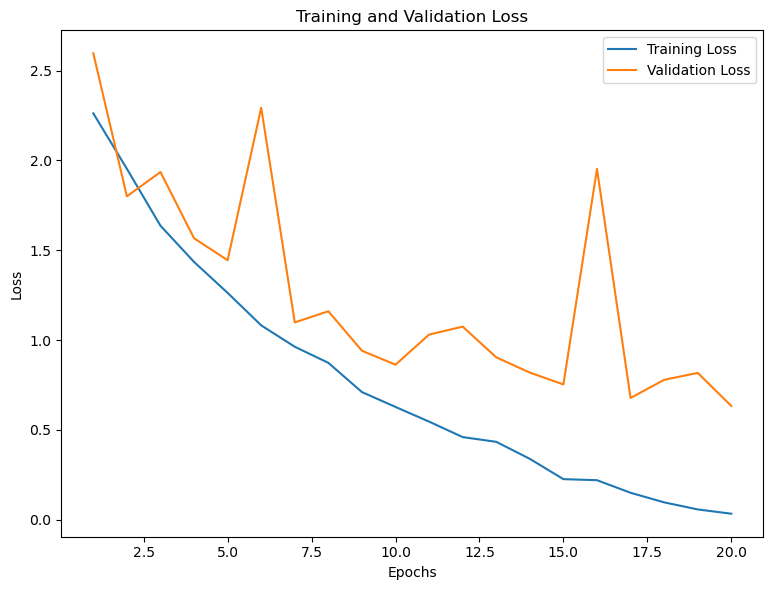

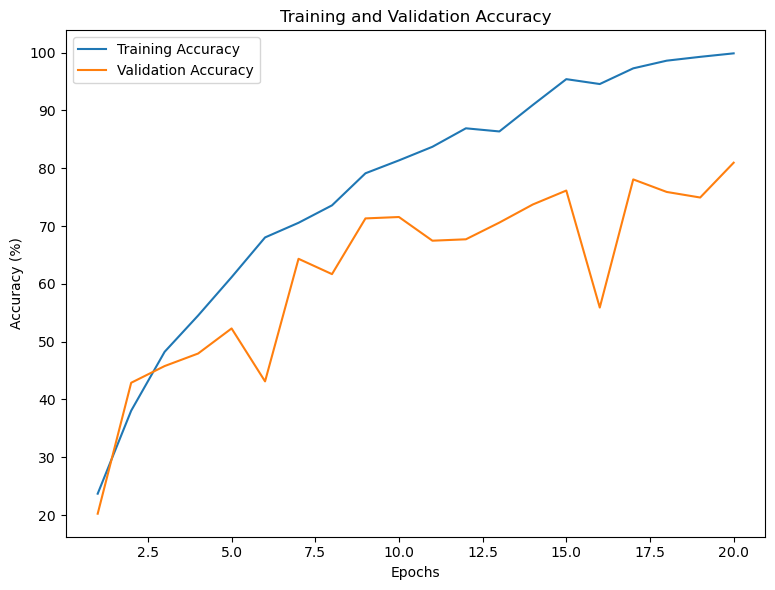

In [9]:
def plots(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# plot everything to check for overfitting
plots(train_losses, val_losses, train_accuracies, val_accuracies)


In [10]:
print('Validation Set Accuracy')
testVal(val_loader, model)

Validation Set Accuracy
Got 336 / 415 correct (80.96)


In [11]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save("../Checkpoints/ResNet34.pt") # Save the model